# Statistical Analysis: Spatial Autocorrelation
The goal of this notebook is to first establish whether there is a statististical correlation between the spatial data and its location, then to identify where the statistically significant spatial clusters are located. The data that will be analyzed is "FEFxCES", which quantifies the joint post-fire-flood risk and social vulnerability. The clusters, which are on the census tract-level, will be used to identify the neighborhoods in Los Angeles County that are environmentally and socially highly vulnerable. 

#### Import necessary libraries

In [2]:
# We will be working with geospatial data
import geopandas as gpd

# Python Spatial Analysis Library (pysal) 
import libpysal as lps

# Exploratory Spatial Data Analysis (esda)
import esda
from esda.moran import Moran, Moran_Local

# Splot connects spatial analysis done in Python Spatial Analysis Library (pysal) 
# to different visualization toolkits like matplotlib
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

# Visualization toolkits
import matplotlib.pyplot as plt
import plotly.express as px

#### Load the geodataframe of interest

In [3]:
tracts = gpd.read_file('data/tracts.geojson')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


The "FEFxCES" column from tracts.geojson will be analyzed. 

#### What does the geodataframe look like?

In [19]:
tracts.sample(5)

,Census_Tract,County,CSA_Type,CSA_Label,DRP_Planning_Area,DPH_Service_Planning_Area,City_of_Los_Angeles_CPA,Population,Children,Older_Adults,...,Shape__Area,Shape__Length,impact,area,scaled_impact,ces,pFEF,FEFxCES,geometry,FEFxCES_lag
2046,Census Tract 4034.06,Los Angeles County,City,City of Walnut,East San Gabriel Valley Planning Area,San Gabriel,None,3019,24.6,13.2,...,1.878458e+06,5624.488332,0.000000,1.286461e+06,0.000000e+00,88.413192,38.783842,0.000000,"POLYGON ((-11372001.028 4098531.807, -11371690...",0.000000
1260,Census Tract 5361.02,Los Angeles County,City,City of South Gate,Gateway Planning Area,East,None,3281,25.0,17.6,...,4.445209e+06,10107.382173,249670.064139,3.051573e+06,8.181685e-02,96.029869,96.476150,4189.477831,"POLYGON ((-11402373.558 4085863.677, -11402194...",1726.270326
2127,Census Tract 2360,Los Angeles County,City,Los Angeles - Baldwin Hills,Westside Planning Area,South,West Adams - Baldwin Hills - Leimert,4373,14.8,21.0,...,5.873380e+06,11531.133367,3.522817,4.025577e+06,8.751087e-07,72.109521,77.567684,456.672654,"POLYGON ((-11421947.923 4095135.942, -11421871...",2633.069035
1113,Census Tract 6021.06,Los Angeles County,City,City of Hawthorne,South Bay Planning Area,South Bay,None,5547,22.3,12.0,...,1.192470e+06,4879.982913,0.000000,8.190378e+05,0.000000e+00,93.602987,38.783842,0.000000,"POLYGON ((-11420660.120 4084976.001, -11420239...",0.000000
61,Census Tract 1951,Los Angeles County,City,Los Angeles - Silverlake,Metro Planning Area,Metro,Silver Lake - Echo Park - Elysian Valley,5013,19.4,16.0,...,2.778366e+06,7858.408785,336376.948351,1.900278e+06,1.770146e-01,NaN,98.581865,1527.235168,"POLYGON ((-11412123.400 4103252.098, -11411783...",1255.795552


Looking at a random sample of 5 rows, it can be observed that some tracts have zero vulnerability while others have FEFxCES values of over 4000. Though all tracts have an assigned Social Vulnerability Index score, not all areas are at risk of experiencing wildfires or flooding. 

## 1.) Global Spatial Autocorrelation: Moran's I Statistic
The Global Spatial Autocorrelation tool measures spatial autocorrelation based on both locations and values simultaneously. Given a set of features and an associated attribute, it evaluates whether the pattern expressed is clustered, dispersed, or random. The tool calculates the Moran's I Index value and p-value to evaluate the significance of that Index ([source](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm)).

#### Spatial Weight
Used to determine the boundaries of who is a neighbor or not

In [4]:
# Calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(tracts,k=8)

# Row-standardization: adjust the weights in the spatial weights matrix, then divide each weight by its row sum. 
# The row sum is the sum of weights for a features neighbors.
wq.transform = 'r'

A spatial weights matrix with 8 nearest neighbors of a tract has been created.

#### Spatial Lag
Captures the behavior of a variable in the immediate surroundings of each location (also known as "local average")

In [5]:
# Create a new column for the spatial lag values
tracts['FEFxCES_lag'] = lps.weights.lag_spatial(wq, tracts['FEFxCES'])

In [6]:
# What does the geodataframe look like now?
tracts.sample(5)[['Census_Tract','CSA_Label','SoVI_Score','FEFxCES','FEFxCES_lag']]

,Census_Tract,CSA_Label,SoVI_Score,FEFxCES,FEFxCES_lag
1761,Census Tract 6024.03,City of Hawthorne,0.62,0.0,0.000000
1948,Census Tract 5732.01,City of Long Beach,4.11,0.0,1556.020171
1068,Census Tract 5763.01,City of Long Beach,2.48,0.0,0.000000
788,Census Tract 4312,Unincorporated - Duarte,-2.33,0.0,0.000000
1409,Census Tract 5340.01,City of Bell Gardens,1.35,0.0,2566.900808


The spatial lag column provides insight into the vulnerability of a particular tract compared to its neighbors. The City of Pomona faces does not face both post-fire-flood risk and social vulnerability risk, and its neighbors also face no such risk. However, though the City of Norwalk itself does not face FEFxCES risk, their neighbors face much more risk.

#### Moran's I Statistic
This equation computes the mean and variance for the attribute being evaluated. Then, for each feature value, it subtracts the mean, creating a deviation from the mean. Deviation values for all 8 neighboring features are multiplied together to create a cross-product. 

In [7]:
# Quantify the degree of spatial correlation by calculating the Moran's I value
y = tracts.FEFxCES
moran = Moran(y, wq)
moran.I

0.33664726505856046

The resulting value is a slope of the scatterplot of the vulnerability value vs. the vulnerability value spatial lag value. 

#### Moran Scatterplot
Visualize the spatial dataset to explore the nature and strength of spatial autocorrelation

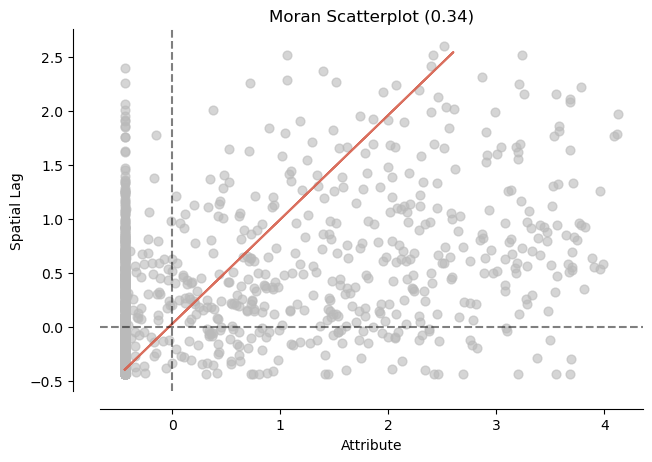

In [8]:
# Create a scatterplot of the vulnerability value (FEFxCES) and its spatial lag value (FEFxCES_lag)
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

The slope of 0.34 indicates that there is a positive autocorrelation between tracts and their neighbors. The line represents the best linear fit to the scatter plot.

#### Moran Simulation
Empirical test to obtain the p-value

/opt/conda/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.34', ylabel='Density'>)

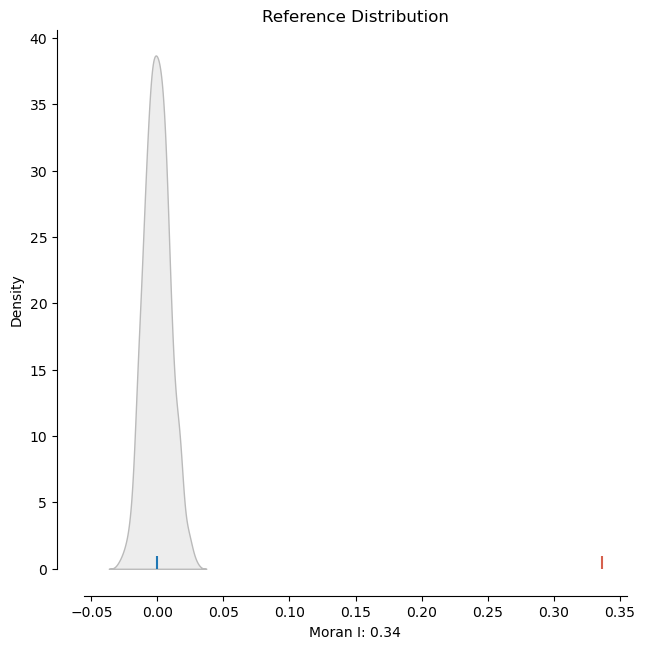

In [9]:
# Run 999 permutations to determine likelihood that the observed geospatial pattern on the map is randomly distributed
plot_moran_simulation(moran,aspect_equal=False)

The output is a reference distribution of Moran's I values under the null hypothesis that the attribute values are randomly distributed across the study area ([source](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)). The red segment is the observed Moran's I value. The blue segment is the likelihood of obtaining a pattern like the one observed under a spatially random process.

#### P-value
Empirical p-value that represents the proportion of realizations in the simulation under spatial randomness that are more extreme than the observed value.

In [10]:
# What is the empirical p-value?
moran.p_sim

0.001

There is a positive spatial autocorrelation between the post-wildfire-flood vulnerable and socially vulnerable communities and their locations. We can reject the null hypothesis that there is no correlation between the geospatial data and their location.

## 2.) Local Spatial Autocorrelation: Local Indicators of Spatial Association (LISAs) 
Now that a statistically significant relationship has been estalished, let us identify where those significant clusters are. LISA is a method that identifies localized map regions where data values are strongly positively or negatively associated with one another.  

#### Local Moran Values

In [11]:
# Calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

#### Moran Local Scatterplot with HH, HL, LH, and LL values

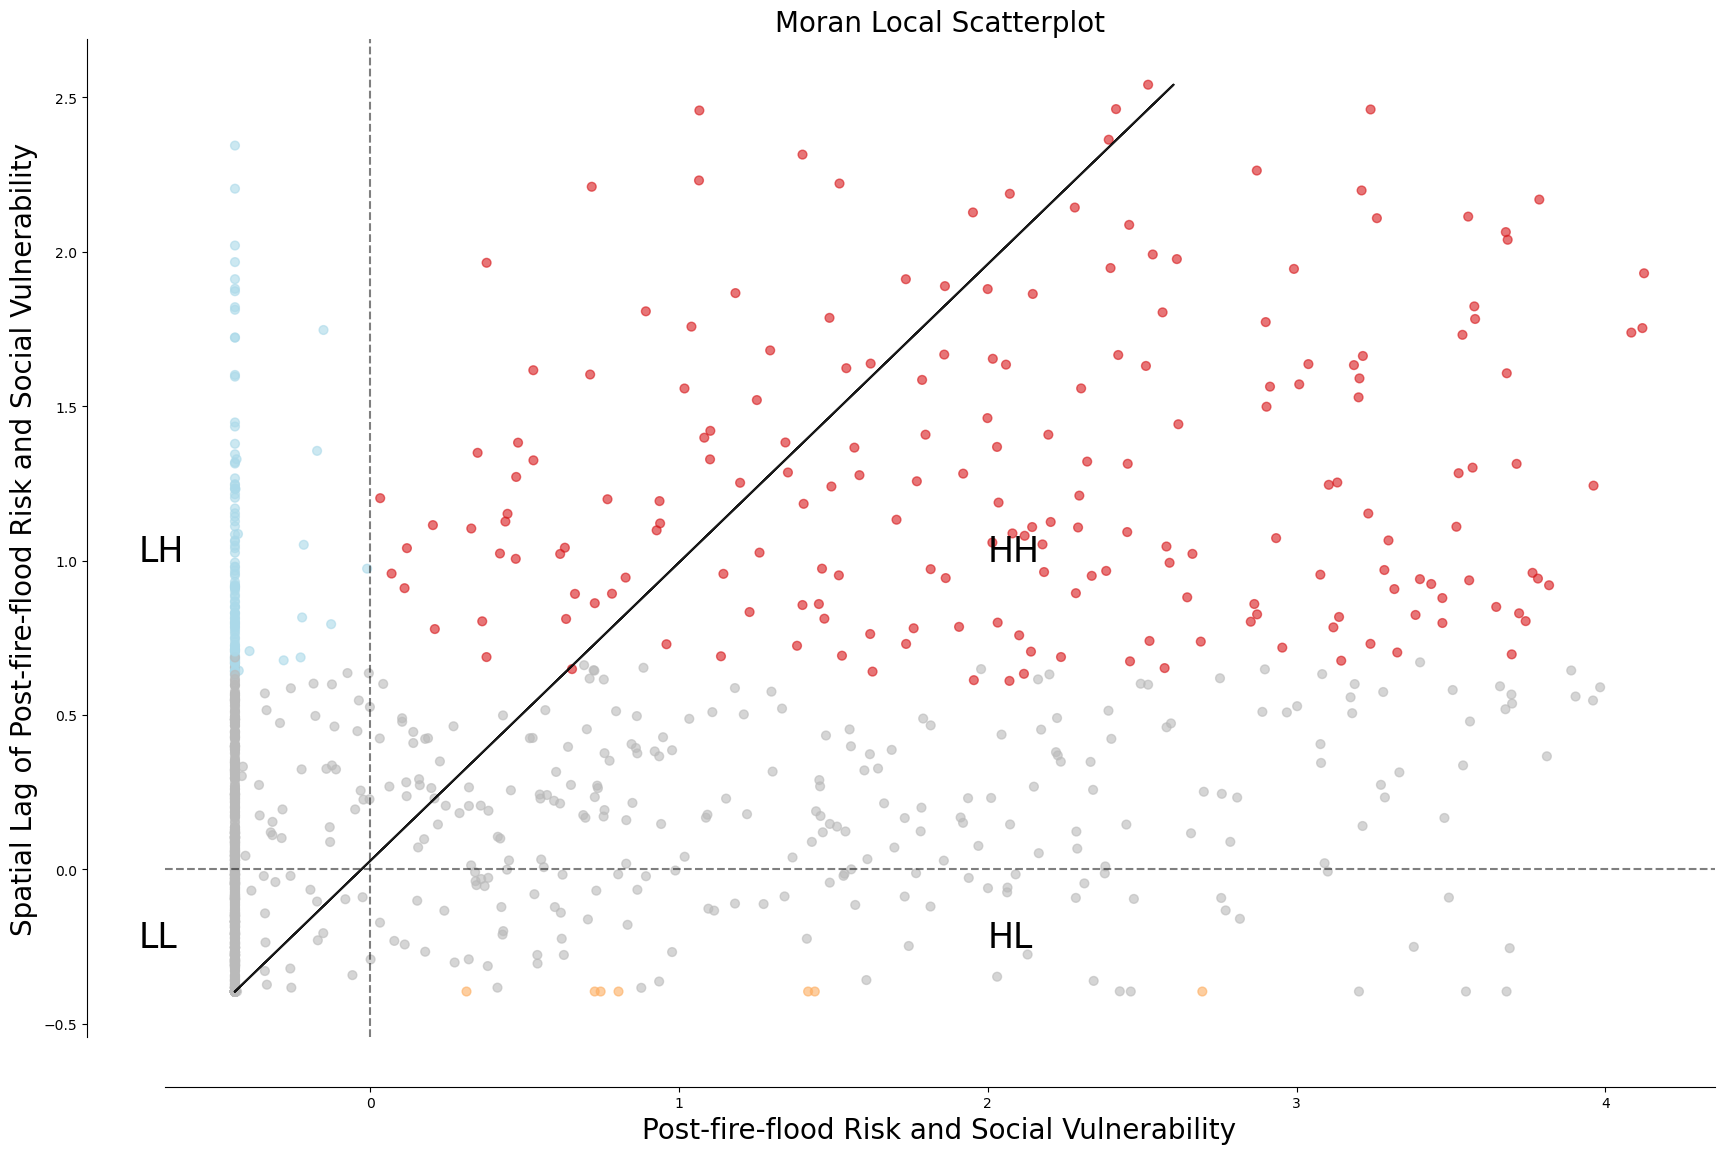

In [20]:
# Create figure
fig,ax = plt.subplots(figsize=(20,15))

# Create scatterplot
moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_title("Moran Local Scatterplot",fontsize=20)
ax.set_xlabel("Post-fire-flood Risk and Social Vulnerability",fontsize=20)
ax.set_ylabel('Spatial Lag of Post-fire-flood Risk and Social Vulnerability',fontsize=20)

# Label the areas
plt.text(2, 1, "HH", fontsize=25)
plt.text(2, -0.25, "HL", fontsize=25)
plt.text(-0.75, 1, "LH", fontsize=25)
plt.text(-0.75, -0.25, "LL", fontsize=25)
plt.show()

With a p-value of 0.05, each value on the scatterplot represents the census tracts that are statistically significantly spatially autocorrelated. HH tracts are highly vulnerable tracts near other highly vulnerabile tracts. HH tract clusters are of interest for the purposes of our research.

## Map of Statistically Significant Spatial Clusters
Now that we have categorized the significant census tracts, let's map them.

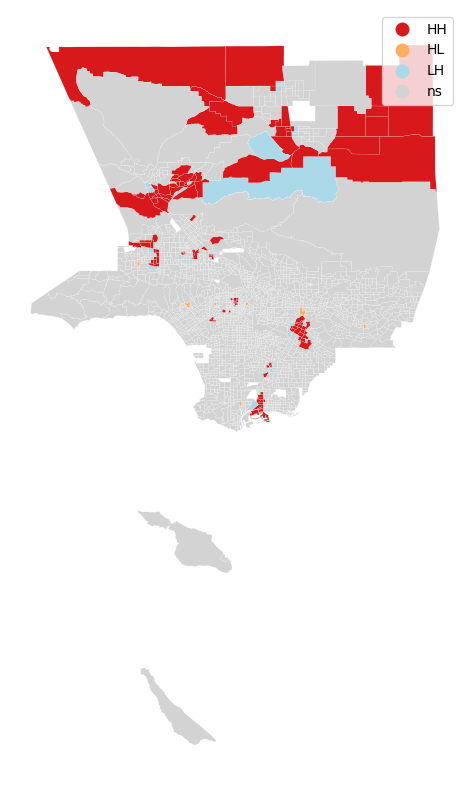

In [37]:
# Create figure
fig, ax = plt.subplots(figsize=(10,10))

# Map the clusters with a p-value of 0.01
lisa_cluster(lisa, tracts, p=0.01, ax=ax)

# Display map
plt.show()

Focusing on the HH clusters, the areas that have joint post-fire-flooding risk and social vulnerability are located around Angeles National Forest, Whittier, and Long Beach. To identify these highly vulnerable locations more specificaly, a neighborhood boundary map will be placed.